# Job Boards for Data Science





**Where to scrape jobs?**

* Indeed
* Glassdoor

**What searches should be scrape for?**

<table style="width:60%">
    <tr>
        <th style="text-align:center">Keyword</th>
        <th style="text-align:center">Location</th>
    </tr>
    <tr>
        <td style="text-align:center">Data Scientist</td>
        <td style="text-align:center">United States</td>
    </tr>
    <tr>
        <td style="text-align:center">Data Scientist</td>
        <td style="text-align:center">California</td>
    </tr>
    <tr>
        <td style="text-align:center">Data Analyst</td>
        <td style="text-align:center">United States</td>
    </tr>
    <tr>
        <td style="text-align:center">Data Analyst</td>
        <td style="text-align:center">California</td>
    </tr>
    <tr>
        <td style="text-align:center">Junior Data Scientist</td>
        <td style="text-align:center">United States</td>
    </tr>
    <tr>
        <td style="text-align:center">Data Scientist New Grad</td>
        <td style="text-align:center">United States</td>
    </tr>
</table>

Total of 12 searches between both job sites. I'm curious if the "California" scrapes will include any jobs that weren't in the "United States" scrapes.

**How should jobs be grouped?**

* Data Scientist
* Senior Data Scientist
* Junior Data Scientist
* Data Analyst
* 2+ years experience
* PhD required
* Data Engineer
* Data Architect
* Director of Data Science
* Manager of Data Science

The main theme is that we want to aggregate jobs around the level of seniority the job entails and then to some degree the type of work (e.g. data scientist vs. data engineer).

<a id="toc"></a>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<h2>Table of Contents</h2>

<br>

<ol>
    <h3><li><a href="#section1">Indeed Web Scraper Class</a></li></h3>
    <br>
    <h3><li><a href="#section2">Glassdoor Web Scraper Class</a></li></h3>
    <br>
    <h3><li><a href="#section3">Analysis of Sample Data</a></li></h3>
</ol>

### Import needed libraries

In [3]:
# web scraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.set_headless(headless=False) # decides whether to show the chrome window while executing web search

# parsing web pages
from bs4 import BeautifulSoup

# allow for scraping many pages at once
import threading

# plotting pacakges
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
%matplotlib inline

# ignore matplotlib/seaborn deprecation warning... it just looks ugly
import warnings
warnings.filterwarnings("ignore", message="The 'normed' kwarg is deprecated, and has been ")

# assortment of other libraries
import re
import time
from nltk.corpus import stopwords
import string
from collections import Counter
import pandas as pd
import numpy as np
import arrow

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section1'></a>

## Building Web Scraping Classes

**Web scrape for Indeed [UNDER CONSTRUCTION]**

In [29]:
def get_indeed_data(job_search_term="Data Scientist", location_search_term="California"):
    
    notification_blocked = False
    pages_searched = 0
    all_jobs = 0
    job_descriptions = []
    job_pages = []

    browser = webdriver.Chrome(chrome_options=chrome_options)

    browser.get('https://www.indeed.com/')

    search_job = browser.find_element_by_id('text-input-what')
    search_job.clear()
    search_job.send_keys(job_search_term)

    location = browser.find_element_by_id('text-input-where') 
    location.clear()
    location.send_keys(location_search_term)
    wait(browser, 3)
    location.send_keys(Keys.RETURN)
    
    pages_searched += 1

    time.sleep(3) # wait for new page to load

    job_pages.append(browser.page_source) # data collection step

    jobs = browser.find_elements_by_class_name('row result clickcard')

    total_jobs = len(jobs)
    all_jobs += total_jobs
    jobs_counter = 0

      
    
    return(job_descriptions, job_pages)

**Web scrape Glassdoor [COMPLETE!]**

In [ ]:
# web scraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
chrome_options = Options()
chrome_options.set_headless(headless=False) # decides whether to show the chrome window while executing web search

# parsing web pages
from bs4 import BeautifulSoup

# allow for scraping many pages at once
import threading

# assortment of other libraries
import re
import time
import string
import pandas as pd
import numpy as np
import arrow
import sys


class glassdoor_scraper():
    
    def __init__(self, job_search_terms, location_search_terms, num_pages=1, all_pages=True):
        
        # main parameters of the web scrape
        self.job_search_terms = job_search_terms
        self.location_search_terms = location_search_terms
        self.num_pages = num_pages
        self.all_pages = all_pages
        self.test = []
        
        assert(len(job_search_terms) == len(location_search_terms)) # has to be equal
        
        # for storing data
        self.all_job_pages = [] # contains all scraped HTML pages
        self.count_jobs = [] # total count of jobs from all scraper threads
        self.df_jobs = pd.DataFrame() # placeholder for a Pandas DataFrame
        
        
        # for storing threads
        self.job_threads = [] # hold job scraping threads
        self.parse_threads = [] # hold job parsing threads

        self.lock = threading.Lock() # avoid race conditions
        
        
    ###############################
    # main program calls directly #
    ###############################
    def search_jobs(self):
        for i in range(len(self.job_search_terms)):
            self.job_threads.append(threading.Thread(target=self.get_glassdoor_jobs, 
                                                 args=(self.job_search_terms[i], self.location_search_terms[i])))
            time.sleep(5)
            self.job_threads[i].start()
            
            
    ###############################
    # main program calls directly #
    ###############################
    def parse_jobs(self):
        for i in range(len(self.job_search_terms)):
            self.parse_threads.append(threading.Thread(target=self.parse_glassdoor_jobs, 
                                                       args=(self.all_job_pages[i],i)))
            time.sleep(5)
            self.parse_threads[i].start()
    
    ######################################   
    # target for threads to get job data #
    ######################################
    def get_glassdoor_jobs(self, search_term, location_term):

        notification_blocked = False
        pages_searched = 0
        job_count = 0
        job_failures = 0
        job_pages = []
        page_count = 0

        # open website
        browser = webdriver.Chrome(chrome_options=chrome_options)
        browser.get('https://www.glassdoor.com/index.htm')

        # Enter search parameters
        search_job = browser.find_element_by_name('sc.keyword')  
        search_job.clear()
        time.sleep(2)
        search_job.send_keys(search_term)
        location = browser.find_element_by_id('LocationSearch')
        location.clear()
        time.sleep(2)
        location.send_keys(location_term)
        time.sleep(2)
        location.send_keys(Keys.RETURN)

        # get data from website
        while page_count < self.num_pages:

            pages_searched += 1

            time.sleep(3) # wait for new page to load

            jobs = browser.find_elements_by_class_name('jl')
            
            if len(jobs) < 20:
                
                for i in range(5):
                    browser.refresh()
                    time.sleep(3)
                    jobs = browser.find_elements_by_class_name('jl')    
                    if len(jobs) > 20:
                        break;
                else:
                    
                    break;
                
                
            
            # get all jobs in a single page
            for job in jobs:
                try: 
                    if not notification_blocked:
                        try:
                            wait(browser, 3)
                            close_button = browser.find_element_by_class_name('mfp-close')
                            close_button.click()
                            notification_blocked = True
                        except:
                            pass

                    job.click()

                    time.sleep(2) # wait for job description to load

                    job_pages.append(browser.page_source) # data collection step
                        
                    job_count += 1
                except:
                    job_failures += 1


            if pages_searched % 10 == 0:
                print("{0} - {1}: mined {2} jobs".format(search_term, location_term, job_count))

            if not self.all_pages:
                page_count += 1
                
            # get the next page of search results
            for i in range(5):
                try:
                    if browser.find_element_by_class_name('next').find_element_by_class_name('disabled'):
                        self.test.append(browser.page_source)
                        print("found disabled button")
                        browser.refresh()
                        time.sleep(3)
                except:
                    pass
                
                try:
                    next_page = browser.find_element_by_class_name('next')
                    next_page.click()
                    break;
                except:
                    time.sleep(2)
                    
            else:
                break;

        browser.quit()
        
        with self.lock:
            self.count_jobs.append(job_count)
            self.all_job_pages.append(job_pages)
            title = "{} - {} | status: ENDED".format(search_term, location_term)
            print(title)
            print("="*len(title))
            print("Number of pages searched = {}".format(pages_searched))
            print("Number of jobs mined = {}".format(job_count))
            print("Number of failed job clicks = {}".format(job_failures))
            print("\n")
          
    ########################## 
    # target for job parsing #
    ##########################
    def parse_glassdoor_jobs(self, job_pages, index):
    
        data_dict = {"company":[], "position":[], "location":[], "link":[], "description":[]}
        count = 0
        # get some data from scraped web pages
        for job in job_pages:

            soup = BeautifulSoup(job, 'html.parser')
            
            try:
                link = soup.find('div', class_="regToApplyArrowBoxContainer").find('a', href=True)['href']
                data_dict["link"].append("https://www.glassdoor.com{}".format(link))
            except:
                data_dict["link"].append("N/A")

            try:
                location = soup.find('div', class_="padLt padBot").findAll('span')
                if len(location) == 4:
                    data_dict["location"].append(location[3].text.split(' ' + chr(8211) + ' ')[1].strip())
                elif len(location) == 1:
                    data_dict["location"].append(location[0].text.split(' ' + chr(8211) + ' ')[1].strip())
            except:
                data_dict["location"].append("N/A")

            try:
                company = soup.find('a', class_="plain strong empDetailsLink")  
                data_dict["company"].append(company.text.strip())
            except:
                data_dict["company"].append("N/A")

            try:
                position = soup.find('h1', class_="noMargTop noMargBot strong")
                data_dict["position"].append(position.text.strip())
            except:
                data_dict["position"].append("N/A")

            try:
                description = soup.find('div', id='JobDescriptionContainer')
                data_dict["description"].append(description.text.strip())
            except:
                data_dict["description"].append("N/A")

            count += 1

            if count % int(len(job_pages)/4) == 0:
                print("Job Search {0}: currently at job {1}".format(index+1,count))

        # package into DataFrame object
        df_tmp = pd.DataFrame.from_dict(data_dict)   

        # reorder columns in more logical way
        old_cols = df_tmp.columns.tolist()
        new_cols = ['position', 'company', 'location', 'description', 'link']
        if set(old_cols) == set(new_cols):
            df_tmp = df_tmp[new_cols]

        with self.lock:
            self.df_jobs = self.df_jobs.append(df_tmp, ignore_index=True)
        
        print("dataframe has been appended.")
    
    ###############################
    # main program calls directly #
    ###############################
    def save_jobs(self, save_location="./data/glassdoor-df-{}.csv".format(arrow.now().format('MM-DD-YYYY'))):
        if not self.df_jobs.empty:
            self.df_jobs.to_csv(save_location, index=False)
            print("Jobs data saved to {}.".format(save_location))
        else:
            print("Jobs DataFrame was empty and thus not saved to file.")
      
    
    
if __name__ == '__main__':
    
    job_terms = ['Data Scientist']
    location_terms = ['California']
    
#     if not sys.argv[1]:
#         raise Exception('Need to provide a text file of search terms to scrape from. See documentation for details.')
    
#     # get search parameters from file
#     try:
#         with open(sys.argv[1]) as file:
#             job_searches = file.readlines()

#             for job_search in job_searches:
#                 keywords = job_search.split("-")
#                 job_terms.append(keywords[0].strip())
#                 location_terms.append(keywords[1].strip())
#     except:
#         print("Issue reading {}. Be sure path is correct and format is correct. See documentation for details.".format(sys.argv[1]))
                
            
    scraper = glassdoor_scraper(job_search_terms=job_terms, location_search_terms=location_terms)
    
    # get job data from glassdoor
    scraper.search_jobs()
    for thread in scraper.job_threads:
        thread.join()
     
    # parse job data into Pandas DataFrame
    scraper.parse_jobs()
    for thread in scraper.parse_threads:
        thread.join()   
    
    print("\n")
    print("Total of {} jobs scraped.".format(np.sum(scraper.count_jobs)))      
    
    # save DataFrame to file
    scraper.save_jobs()
    
    print("\n")
    print("JOB SCRAPE IS COMPLETE!")

In [6]:
browser = webdriver.Chrome(chrome_options=chrome_options)
browser.get('https://www.glassdoor.com/index.htm')

search_job = browser.find_element_by_name('sc.keyword')  
search_job.clear()
time.sleep(2)
search_job.send_keys('hi there')

keyword = browser.find_element_by_name('sc.keyword').get_attribute('value')

print(keyword)

hi there


In [8]:
keyword[0]

'h'

In [33]:
soup = BeautifulSoup(scraper.test[0], 'html.parser')

IndexError: list index out of range

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section2'></a>

## Analysis of Sample Data

In [26]:
df = pd.read_csv('./data/glassdoor-df-06-05-2018.csv', encoding="ISO-8859-1")

In [27]:
df.shape

(60, 5)

In [28]:
df.head(n=10)

,position,company,location,description,link
0,Data Scientist,NinthDecimal,"Mountain View, CA",Data Scientist @ NinthDecimal.\r\n\r\nNinthDec...,https://www.glassdoor.com/partner/jobListing.h...
1,Scientist,Singulex,"Alameda, CA",About Singulex:\r\nSingulex is an immunodiagno...,https://www.glassdoor.com/partner/jobListing.h...
2,Data Scientist,Facebook,"Menlo Park, CA",Facebook's mission is to give people the power...,https://www.glassdoor.com/partner/jobListing.h...
3,Data Scientist,23andMe,"Mountain View, CA",23andMe is seeking an experienced data scienti...,https://www.glassdoor.com/partner/jobListing.h...
4,Data Scientist,Stripe,"San Francisco, CA",Generate insights and impact from data.\r\n\r\...,https://www.glassdoor.com/partner/jobListing.h...
5,Data Science Engineer (Data Scientist),Plume,"Palo Alto, CA","Job summary\r\n\r\nJoin a small, highly skille...",https://www.glassdoor.com/partner/jobListing.h...
6,Data Scientist,Esri,"Redlands, CA",OverviewMachine learning is the top focus of a...,https://www.glassdoor.com/partner/jobListing.h...
7,Data Scientist,Rakuten,"San Mateo, CA","Rakuten, Inc. is the largest ecommerce company...",https://www.glassdoor.com/partner/jobListing.h...
8,Data Scientist,Credit Karma,"San Francisco, CA",Credit Karmaâs fast growing Data Sciences te...,https://www.glassdoor.com/partner/jobListing.h...
9,Data Scientist,Qventus,"Mountain View, CA",Want to unlock insights from data to help doct...,https://www.glassdoor.com/partner/jobListing.h...


**Plotting the distribution of dates:**

#### [UPDATE] 

I am no longer collecting the time data from glassdoor, so I can no longer create this plot, but I'll keep this here as it is interesting to see.

In the future I will build my own time component to jobs as this will be more accurate but will take about a month to get aligned properly.

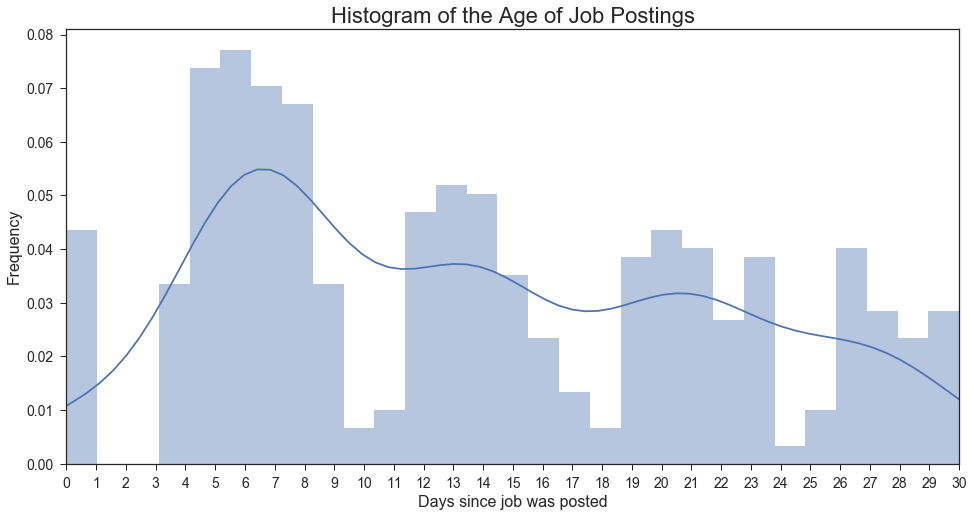

In [459]:
# get the data ready
times = [int(x) for x in df['time'].tolist() if x is not None]
min_time = np.min(times)
max_time = np.max(times)
num_bins = len(set(times))

sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(16,8))
major_ticks = np.arange(min_time,max_time+1,1)
sns.distplot(times, bins=num_bins, ax=ax)
ax.set_title("Histogram of the Age of Job Postings", fontsize=22);
ax.set_ylabel("Frequency", fontsize=16);
ax.set_xlabel("Days since job was posted", fontsize=16);
ax.tick_params(labelsize=14);
ax.set_xticks(major_ticks, minor=False);
plt.xlim(min_time,max_time);

**Two things to notice:**

1) Most job postings are less than a week old and drop off steadily over time. This is likely why Glassdoor just says "30+" when a job posting is more than 30 days old.

2) The data appears to cycle. Without looking into the data to confirm, the obvious interpretation is that employers aren't as likely to post jobs on the weekend.

**Let's analyze where the jobs are coming from**

Remember, the search location was "California" so while we expect all jobs to be in the state of California, let's see if we can see what the city distribution is.

### Analyzing words in job postings

In [461]:
counted_words = parse_top_terms_glassdoor(job_descriptions)

In [462]:
words = []
counts = []

for word in counted_words.keys():
    words.append(word)
    counts.append(counted_words[word])
    
df_word_counts = pd.DataFrame({"word":words, "count":counts})

In [463]:
df_word_counts.shape

(19318, 2)

We scraped thousands of unique words from the job descriptions, however, even though we filtered out simple words like "the", "a", "of", most words in the list are not exactly data science skills:

In [464]:
df_word_counts= df_word_counts.sort_values("count", ascending=False)
df_word_counts.head(n=20)

,count,word
14277,7979,data
11371,3589,experience
4741,2389,science
14110,2379,team
6417,2168,business
15721,1958,work
2675,1595,learning
19047,1464,product
2517,1259,machine
17372,1225,analytics


Terms like "data science" that were split into two tokens both rank highly (not interesting / useful to us) and words like "experience" may say something interesting about data science job postings, perhaps that most require significant experience OR it might just be a common heading in job descriptions as might be "responsibilities" or "education".

At any rate, it would be more interesting to see the relative frequency of certain data science tools.

**Define a list of words of interest to filter on**

In [465]:
data_science_words = ['python','sql','r','hadoop','spark','d3.js','hive','matlab','excel',
                      'nosql','aws','c','java','javascript','php','scala','tableau','cassandra',
                      'etl','javascript','mahout','redis','redshift','machine','learning','deep',
                      'tensorflow','keras','matplotlib','Ruby','Pig','mongodb','mysql','pandas',
                      'numpy','scipy','linux','windows'
                     ]

In [466]:
df_ds_words = df_word_counts[df_word_counts["word"].isin(data_science_words)]

In [467]:
df_ds_words = df_ds_words.sort_values("count", ascending=False)

In [468]:
df_ds_words.head(n=10)

,count,word
2675,1595,learning
2517,1259,machine
11911,631,python
17273,504,sql
7526,420,r
2413,361,deep
8767,248,spark
11078,210,hadoop
18860,182,java
5494,138,aws


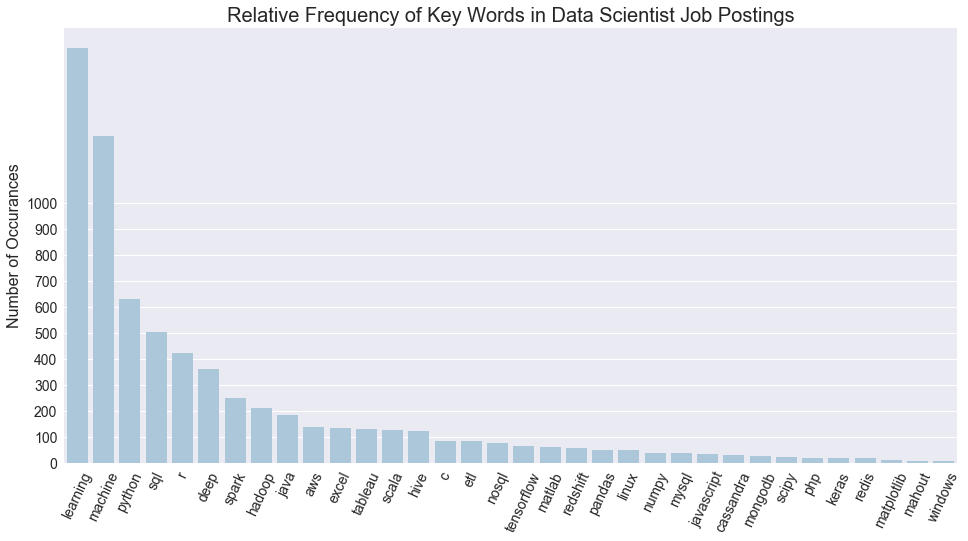

In [469]:
sns.set(style='darkgrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x="word",y="count", color="#a5c8e1", data=df_ds_words);
ax.set_xticklabels(ax.get_xticklabels(),rotation=65);
ax.set_title("Relative Frequency of Key Words in Data Scientist Job Postings", fontsize=20);
ax.set_ylabel("Number of Occurances", fontsize=16);
ax.set_xlabel("");
ax.tick_params(labelsize=14);
major_ticks = np.arange(0,1501,100)
ax.set_yticks(major_ticks, minor=False);

***

## TEST SECTION

***

<div align="center">
    <a href="#toc">back to top</a>
</div>